<a href="https://colab.research.google.com/github/xslittlemaggie/Deep-Learning-Machine-Learning-Projects/blob/master/Wine_DecisionTree_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> Wine with Decision Tree & Random Forest  </center></h1>

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 24px">
    <ol>
        <li><a href="#Part One">Part One: Decision Tree from scratch</a></li>
        <li><a href="#Part Two">Part Two: Decision Tree from sklearn</a></li>
      <li><a href="#Part Three">Part Three: Random Forest from sklearn</a></li>
    </ol>
</div>
<br>
<hr>

# Part One: Realization of Decesion Tree from Scratch

## Step 1: Calculate gini impurity
The lower the better, more pure

In [0]:
from collections import Counter

def gini(labels):
    impurity = 1
    label_counts = Counter(labels)
    for label in label_counts:
      probability_of_label = label_counts[label]/len(labels)
      impurity -= probability_of_label ** 2
    return impurity

## Step 2: Calculate information gain

In [0]:
def information_gain(starting_labels, split_labels):
  info_gain = gini(starting_labels)
  for subset in split_labels:
    info_gain -= gini(subset) * len(subset)/len(starting_labels)
  return info_gain

## Step 3: Split data based on different features (column)

#### 3.1 split data based on each feature

In [0]:
cars = [['med', 'low', '3', '4', 'med', 'med'], 
        ['med', 'vhigh', '4', 'more', 'small', 'high'], 
        ['high', 'med', '3', '2', 'med', 'low'], 
        ['med', 'low', '4', '4', 'med', 'low'], 
        ['med', 'low', '5more', '2', 'big', 'med'], 
        ['med', 'med', '2', 'more', 'big', 'high'], 
        ['med', 'med', '2', 'more', 'med', 'med'], 
        ['vhigh', 'vhigh', '2', '2', 'med', 'low'], 
        ['high', 'med', '4', '2', 'big', 'low'], 
        ['low', 'low', '2', '4', 'big', 'med']]


car_labels = ['acc', 'acc', 'unacc', 'unacc', 'unacc', 'vgood', 'acc', 'unacc', 'unacc', 'good']

def split(dataset, labels, column):
    data_subsets = []
    label_subsets = []
    counts = list(set([data[column] for data in dataset]))
    counts.sort()
    for k in counts:
        new_data_subset = []
        new_label_subset = []
        for i in range(len(dataset)):
            if dataset[i][column] == k:
                new_data_subset.append(dataset[i])
                new_label_subset.append(labels[i])
        data_subsets.append(new_data_subset)
        label_subsets.append(new_label_subset)
    return information_gain(labels, label_subsets)


In [0]:
for i in range(6):
  data_subsets, label_subsets = split(cars, car_labels, i)
  print("The information gain for feature {} is: {:.4f}.".format(i + 1, information_gain(car_labels, label_subsets)))
 

The information gain for feature 1 is: 0.2733.
The information gain for feature 2 is: 0.0400.
The information gain for feature 3 is: 0.1067.
The information gain for feature 4 is: 0.3067.
The information gain for feature 5 is: 0.1500.
The information gain for feature 6 is: 0.2900.


#### 3.2 split data based on best feature

In [0]:
def find_best_split(dataset, labels):
    best_gain = 0
    best_feature = 0
    for feature in range(len(dataset[0])):
        data_subsets, label_subsets = split(dataset, labels, feature)
        gain = information_gain(labels, label_subsets)
        if gain > best_gain:
            best_gain, best_feature = gain, feature
    return best_feature, best_gain

In [0]:
find_best_split(cars, car_labels)

(3, 0.3066666666666667)

Thus, from the result above, when split the data with the fourth feature (indexed from 0), the information gain is highest. This is the best feature to split on.

## Step 4: Recursive Tree Building
Now that we can find the best feture to split the dataset, we can repeate this process again and again to create the full tree. This is cursive algorithm! We start with every data point from the trinign set, find the best feature to split the data, split the data based on that feature, and then recursively repeat the process again on each subset that was created from the split.

We'll stop the recursion when we can no longer find a feature that results in any information gain. In other words, we want to create a leaf of the tree when we can't find a way to split the data that makes purer subsets.

The leaf should keep track of the classes of the data points from the trining set that ended up in the leaf. In our inplementation, we'll use a Counter object to keep track of the counts of labels. 

In [0]:
def build_tree(data, labels):
  best_feature, best_gain = find_best_split(data, labels)
  if best_gain == 0:
    return Counter(labels)
  data_subsets, label_subsets = split(data, labels, best_feature)
  branches = []
  for i in range(len(data_subsets)):
    tree = build_tree(data_subsets[i], label_subsets[i])
    branches.append(tree)
  return branches


# Part Two: Decision Tree in scikit-learn

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt

### 1. upload the wine data for practice

In [0]:
df_wine = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 
                   'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


### 2. data preprocessing

In [0]:
y = df_wine['Class label'].values  # all 3 classes
X = df_wine.values[:, 1:]   # all features

le = LabelEncoder()
y = le.fit_transform(y)  # transform label to 0 and 1

In [0]:
X.shape

(178, 13)

In [0]:
y.shape

(178,)

### 3. split the data into training, validatioin datasets

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)  # choose 20% of the data as validation dataset

### 4. create and train the model

In [0]:
# create the model
classifier = DecisionTreeClassifier(random_state = 0)

# train the model
classifier.fit(x_train, y_train)


# make predictions based on the model
predictions = classifier.predict(x_test)

# evaluate the model
round(classifier.score(x_test, y_test), 4) # evaluate the model, get predictions 

0.9167

In [0]:
classifier.tree_.max_depth  # get the depth of the tree

5

### 5. prune the tree by seting the max_depth

The current tree depth is 5. Let's prune it, and set the parameter max_depth to 4, and check the score

Note: Since the max_depth is 5, not too big. There is no overfitting. Decrease the max_depth may not increase the score for this case.

In [0]:
classifier = DecisionTreeClassifier(max_depth = 4, random_state = 0)

# train the model
classifier.fit(x_train, y_train)


# make predictions based on the model
predictions = classifier.predict(x_test)

# evaluate the model
round(classifier.score(x_test, y_test), 4) # evaluate the model, get predictions 

0.9167

### 6. visualize the score with different max_depth

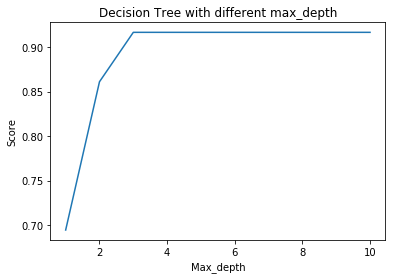

In [0]:
scores = []
for i in range(1, 11):
  classifier = DecisionTreeClassifier(max_depth = i, random_state = 0)
  classifier.fit(x_train, y_train)
  scores.append(classifier.score(x_test, y_test)) # evaluate the model, get predictions 

plt.plot(range(1, 11), scores)
plt.title("Decision Tree with different max_depth")
plt.xlabel('Max_depth')
plt.ylabel('Score')
plt.show()

# Part Three: Decision Tree Limitations

- 1. The current strategy of creating trees is greedy. We can only get the local optimal.

It iwill find the largest information gain right now and split on that feature. We never consider the ramifications of that split futher down the tree. 

Finding a globally optimal tree is an extremely difficult task, and finding a tree using our greedy approach is reasonable substitute.

- 2. Another problem with our trees is that they potentially overfit the data. 

This means that the structure of the tree is too dependent on the training data and doesn't accurately represent the way the data in the real world looks like. In general, larger trees tend to overfit the data more. As the tree gets bigger, it becomes more tuned to the training data and it loses a more generalized understanding of the real world data

One way to solve the overfitting problem is to prune the tree. The goal of pruning is to shrink the size of the tree. There are a few different pruning strategies. 

## Other notes: transform string variable into numerical

In [0]:
#data['sex_int'] = data['sex'].apply(lambda row:0 if row == 'Male' else 1)

#data["country-int"] = data['native-country'].apply(lambda row : 0 if row == "United-States" else 1)